**Christou Nektarios - High Scale Analytics 2022-2023 NKUA**

<p align="justify">This educational project assesses MinHash Locality Sensitive Hashing (LSH) for text document similarity. It compares LSH with a k-Nearest Neighbors (kNN) model using BART embeddings as ground truth. The project involves data preprocessing, shingle creation, and LSH experiments with varying parameters. Findings help understand LSH's efficiency and guide its use in document similarity tasks, enhancing knowledge of LSH techniques and applications.</p






# Packages

In [1]:
!pip install datasketch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 3.0 MB/s eta 0:00:00


In [2]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 14.3 MB/s eta 0:00:00


In [3]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.8 MB/s eta 0:00:00


# Imports

In [4]:
import re
import time
import nltk
import torch
import numpy as np
import pandas as pd
import contractions
import seaborn as sns
from typing import Iterable
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from datasketch import MinHash, MinHashLSH
from sklearn.neighbors import NearestNeighbors
from transformers import AutoTokenizer, AutoModel
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import BayesianGaussianMixture

# Functions

Let's define some usefull functions that are going to help us perform our experiments.

In [5]:
def pre_process(dataset: Iterable):
    """
    Pre-process a dataset, including text cleaning and tokenization.

    Parameters:
    dataset (list): A list containing text data.

    Returns:
    pd.DataFrame: A DataFrame with cleaned text data.
    """
    stop_words = set(stopwords.words('english'))

    cleaned_dataset = []
    for text in dataset:
        cleaned_text = text.lower()
        cleaned_text = BeautifulSoup(cleaned_text, "lxml").get_text()
        cleaned_text = re.sub(r'\([^)]*\)', '', cleaned_text)
        cleaned_text = re.sub('"', '', cleaned_text)
        cleaned_text = contractions.fix(cleaned_text)
        cleaned_text = re.sub(r"'s\b", "", cleaned_text)
        cleaned_text = re.sub("[^a-zA-Z]", " ", cleaned_text)
        cleaned_text = re.sub('[m]{2,}', 'mm', cleaned_text)

        tokens = [w for w in cleaned_text.split() if w not in stop_words]

        long_words = []
        for i in tokens:
            if len(i) > 1:  # removing short word
                long_words.append(i)
        cleaned_dataset.append((" ".join(long_words)).strip())

    cleaned_dataset = pd.DataFrame(cleaned_dataset, columns=['text'])

    return cleaned_dataset


def filter_dataset_by_document_length(dataset):
    """
    Filter a dataset by the majority cluster based on document length.

    Parameters:
    - dataset (pd.DataFrame): A DataFrame containing text data.

    Returns:
    - pd.DataFrame: Filtered dataset based on the majority cluster.
    """
    cluster_df, majority_cluster = cluster_documents_by_length(dataset)

    majority_indices = cluster_df[
        cluster_df['cluster'] == majority_cluster].index

    dataset_filtered = dataset.loc[majority_indices]

    # Print the majority integer value and its corresponding indices
    print("Majority Cluster:", majority_cluster)
    print("Number of indices belonging to the majority cluster:",
          majority_indices.shape[0])
    print("Number of indices of original dataset:", dataset.shape[0])
    print()

    return dataset_filtered


def cluster_documents_by_length(dataset):
    """
    Cluster documents in a dataset based on document length.

    Parameters:
    - dataset (pd.DataFrame): A DataFrame containing text data.

    Returns:
    - pd.DataFrame: Dataframe with cluster information.
    - int: The majority cluster.
    """

    # calculate document lengths
    document_lengths = dataset['text'].apply(len)
    document_lengths = document_lengths.values.reshape(-1, 1)

    cluster_df = pd.DataFrame()
    cluster_df['cluster'] = []

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(document_lengths)

    gmm = BayesianGaussianMixture(n_components=10)

    # Fit the model to your data
    gmm.fit(scaled_data)

    # Predict cluster assignments
    cluster_labels = gmm.predict(scaled_data)
    cluster_df['cluster'] = cluster_labels

    # Find the most significant cluster
    cluster_weights = np.round(gmm.weights_, 2)
    majority_cluster = np.argmax(cluster_weights)

    return cluster_df, majority_cluster


def float_range(start, stop, step):
    """
    Generate a range of floating-point numbers with a specified step.

    Parameters:
    - start (float): The start of the range.
    - stop (float): The end of the range.
    - step (float): The step size.

    Returns:
    - Generator: A generator for the range of floating-point numbers.
    """
    current = start
    while current < stop:
        yield round(current, 2)
        current += step


class Timer:
    # Timer class for measuring execution time
    def __init__(self):
        self.elapsed_time = None

    def __enter__(self):
        self.start_time = time.time()

    def __exit__(self, *args):
        end_time = time.time()
        self.elapsed_time = end_time - self.start_time


Now we'll define a class LSH that will perform necessary functions during the MinHash LSH experiments.

In [6]:
class LSH:
    def __init__(self, n_perm=16, threshold=0.2):
        """
        Initialize the LSH (Locality Sensitive Hashing) object.

        Parameters:
        - n_perm (int): Number of permutations for MinHash.
        - threshold (float): Jaccard similarity threshold for LSH.

        Initializes a MinHashLSH index with the specified threshold and number
        of permutations.
        """
        self.n_perm = n_perm
        self.threshold = threshold
        self.lsh_model = MinHashLSH(threshold=threshold, num_perm=n_perm)

    def fit(self, shingles: Iterable) -> None:
        """
        Fit the LSH (Locality Sensitive Hashing) model with MinHash
        signatures for training data.

        Parameters:
        - shingles (list): A list of shingled documents for the training dataset.

        This method generates MinHash signatures for each training document and
        inserts them into the
        LSH index for future querying.
        """
        for i, doc in enumerate(shingles):
            m = MinHash(num_perm=self.n_perm)
            m.update_batch([shingling.encode('utf-8') for shingling in doc])
            self.lsh_model.insert(f'{i}', m)

    def query(self, minhash_signatures):
        """
        Query the LSH model to find neighbors for the test data using MinHash signatures.

        Parameters:
        - minhash_signatures: MinHash signatures for test data.

        Returns:
        - neighbors_lsh: A list of neighbors for each data point in the test set.

        This method queries the LSH model using MinHash signatures and returns
        a list of neighbor indices
        for each data point in the test set.
        """
        neighbors_lsh = minhash_signatures['signatures'].apply(
            lambda x: self.lsh_model.query(x)
        )
        # Reformat the results to be lists of integers
        neighbors_lsh = [[int(indice) for indice in neighbors] for neighbors in neighbors_lsh]

        return neighbors_lsh

    def produce_signatures(self, data: Iterable):
        """
        Generate MinHash signatures for a set of shingled documents.

        Parameters:
        - data (list): A list containing shingled documents.

        Returns:
        - signatures (list): A list of MinHash signatures for the input data.

        This method generates MinHash signatures for a list of shingled documents
        and returns them as a list.
        """
        signatures = []
        for doc in data:
            m = MinHash(num_perm=self.n_perm)
            m.update_batch([shingling.encode('utf8') for shingling in doc])
            signatures.append(m)

        return signatures

    def update_params(self, n_perm, threshold) -> None:
        """
        Update the LSH model parameters (number of permutations and threshold).

        Parameters:
        - n_perm (int): Number of permutations for MinHash.
        - threshold (float): Jaccard similarity threshold for LSH.

        This method allows you to update the parameters of the LSH model,
        including the number of permutations and threshold.
        """
        self.n_perm = n_perm
        self.threshold = threshold
        self.lsh_model = MinHashLSH(threshold=threshold, num_perm=n_perm)


In [7]:
class KNN:
    def __init__(self, n_neighbors):
        """
        Initialize the k-NN model with the specified number of neighbors.

        Parameters:
        - n_neighbors: The number of neighbors to consider in k-NN.

        This constructor creates a k-NN model with the given number of neighbors
        and sets up the necessary parameters.
        """
        self.n_neighbors = n_neighbors
        self.nn_model = NearestNeighbors(n_neighbors=n_neighbors, algorithm='brute', metric='euclidean')

    def fit(self, data):
        """
        Train the k-NN model on the provided data.

        Parameters:
        - data: The training data used to train the k-NN model.

        This method trains the k-NN model on the provided training data using
        the "brute" force algorithm.
        It measures and prints the execution time for training.
        """
        print('Training NearestNeighbors...')
        self.nn_model.fit(data)

    def query(self, data):
        """
        Query the k-NN model to find neighbors for the test data.

        Parameters:
        - data: The test data for which neighbors are to be found.

        Returns:
        - neighbors_knn: A list of neighbors for each data point in the test set.

        This method queries the k-NN model to find neighbors for the test data.
        It iterates through the test data samples and returns a list of neighbor
        indices for each data point in the test set.
        """
        print('Querying NearestNeighbors...')
        neighbors_knn = []
        for sample in data:
            _, indices = self.nn_model.kneighbors(sample.reshape(1, -1))
            neighbors = indices.tolist()[0]
            neighbors_knn.append(neighbors)

        return neighbors_knn


In [33]:
class Experiment:
    def __init__(self, data, knn, lsh):
        self.knn = knn
        self.lsh = lsh
        self.data = data

    def knn_experiment(self, embeddings_train, embeddings_test):
        """
        Perform k-Nearest Neighbors (k-NN) experiment on the given embeddings.

        Parameters:
        - embeddings_train: The training data embeddings.
        - embeddings_test: The test data embeddings to query against.

        Returns:
        - performance_metrics: A dictionary containing the following performance
          metrics:
            - 'neighbors_knn': Neighbors found by k-NN for the test data.
            - 'time_knn_fit': Time taken to fit (train) the k-NN model.
            - 'time_knn_query': Time taken to query the k-NN model with test
                                data.

        This function fits a k-NN model to the training data embeddings and
        then queries the model with the test data embeddings to find nearest
        neighbors. It measures the time taken for both fitting and querying
        and returns these metrics along with the found neighbors.

        Note: The k-NN model used for this experiment is specified in the KNN
              object.
        """
        nn_model = self.knn

        # train
        timer_knn_fit = Timer()
        with timer_knn_fit:
            nn_model.fit(embeddings_train)

        # query
        timer_knn_query = Timer()
        with timer_knn_query:
            neighbors_knn = nn_model.query(embeddings_test)

        performance_metrics = {'neighbors_knn': neighbors_knn,
                               'time_knn_fit': timer_knn_fit.elapsed_time,
                               'time_knn_query': timer_knn_query.elapsed_time}

        return performance_metrics

    def _lsh_experiment(self, experiment_params):
        """
        Perform a MinHash Locality-Sensitive Hashing (LSH) experiment with the
        given parameters.

        Parameters:
        - experiment_params: A dictionary containing the following experiment
          parameters:
            - 'train': Training data shingles.
            - 'test': Test data shingles to query against.
            - 'experiment_permutations': The number of permutations for MinHash.
            - 'experiment_threshold': The similarity threshold for LSH.

        Returns:
        - experiment_metrics: A dictionary containing the following experiment
          metrics:
            - 'experiment_neighbors': Neighbors found by LSH for the test data.
            - 'experiment_time_fit': Time taken to fit (train) the LSH model.
            - 'experiment_time_query': Time taken to query the LSH model with
                                       test data.

        This function performs a MinHash LSH experiment with the specified
        parameters. It updates the LSH model with the number of permutations
        and similarity threshold, fits the model to the training data shingles,
        generates MinHash signatures for the test set, queries the LSH model,
        and measures the time taken for fitting and querying. The experiment
        results are returned as metrics.

        Note: The LSH model used for this experiment is specified in the LSH
        object.
        """
        X_train_shingles = experiment_params['train']
        X_test_shingles = experiment_params['test']
        permutations = experiment_params['experiment_permutations']
        threshold = experiment_params['experiment_threshold']

        lsh_model = self.lsh

        lsh_model.update_params(n_perm=permutations, threshold=threshold)

        # train
        experiment_timer_fit = Timer()
        with experiment_timer_fit:
            lsh_model.fit(X_train_shingles)

        # Generate MinHash signatures for the test set
        test_signatures = lsh_model.produce_signatures(X_test_shingles)
        test_signatures_df = pd.DataFrame({'signatures': test_signatures})

        # Query
        experiment_timer_query = Timer()
        with experiment_timer_query:
            experiment_neighbors = lsh_model.query(test_signatures_df)

        experiment_metrics = {'experiment_neighbors': experiment_neighbors,
                              'experiment_time_fit': experiment_timer_fit.elapsed_time,
                              'experiment_time_query': experiment_timer_query.elapsed_time}

        return experiment_metrics

    def multiple_lsh_experiments(self, experiments_params):
        """
        Perform multiple MinHash LSH experiments with varying parameters.

        Parameters:
        - experiments_params: A dictionary containing experiment parameters, including:
            - 'experiments_data': A dictionary with training and test data shingles.
            - 'experiments_permutations': A list of MinHash permutations.
            - 'experiments_thresholds': A list of similarity thresholds.

        Returns:
        - experiments_metrics: A dictionary containing experiment metrics:
            - 'experiments_neighbors': Lists of neighbors found in each experiment.
            - 'experiments_time_fit': Times taken for fitting in each experiment.
            - 'experiments_time_query': Times taken for querying in each experiment.
            - 'experiments_permutations': Permutations used in each experiment.
            - 'experiments_thresholds': Similarity thresholds in each experiment.

        This function conducts multiple MinHash LSH experiments with different permutations
        and similarity thresholds. It loops through specified permutations and thresholds,
        conducts an experiment for each combination, records neighbors found, and measures
        the time taken for fitting and querying the LSH model. The results are returned.
        """
        X_train_shingles = experiments_params['experiments_data']['train']
        X_test_shingles = experiments_params['experiments_data']['test']

        _experiments_thresholds = experiments_params['experiments_thresholds']
        _experiments_permutations = experiments_params[
            'experiments_permutations']

        n_experiments = len(_experiments_permutations) * len(
            _experiments_thresholds)

        print(f'Commencing MinHash LSH experiments ({n_experiments})...')

        experiments_counter = 0
        experiments_neighbors = []  # list of lists
        experiments_time_fit = []
        experiments_time_query = []
        experiments_permutations = []
        experiments_threshold = []
        for experiment_threshold in _experiments_thresholds:
            for experiment_permutations in _experiments_permutations:
                print(f'LSH Experiment {experiments_counter} - '
                      f'threshold: {experiment_threshold}, '
                      f'n_perm: {experiment_permutations}')

                experiment_params = {'train': X_train_shingles,
                                     'test': X_test_shingles,
                                     'experiment_permutations': experiment_permutations,
                                     'experiment_threshold': experiment_threshold}

                # fit & query
                experiment_metrics = self._lsh_experiment(experiment_params)

                # extract
                experiment_neighbors = experiment_metrics[
                    'experiment_neighbors']
                experiment_time_fit = experiment_metrics['experiment_time_fit']
                experiment_time_query = experiment_metrics[
                    'experiment_time_query']

                # save
                experiments_neighbors.append(experiment_neighbors)
                experiments_time_fit.append(experiment_time_fit)
                experiments_time_query.append(experiment_time_query)
                experiments_permutations.append(experiment_permutations)
                experiments_threshold.append(experiment_threshold)

                experiments_counter += 1

        experiments_metrics = {'experiments_neighbors': experiments_neighbors,
                               'experiments_time_fit': experiments_time_fit,
                               'experiments_time_query': experiments_time_query,
                               'experiments_permutations': experiments_permutations,
                               'experiments_thresholds': experiments_threshold}

        return experiments_metrics

    def evaluate_experiments(self, neighbors_knn, experiments_neighbors_lsh,
                             experiments_thresholds):
        """
        Evaluate the similarity between k-NN neighbors and LSH experiments neighbors.

        Parameters:
        - neighbors_knn: Neighbors found by k-NN for the test data.
        - experiments_neighbors_lsh: List of lists containing neighbors found by
                                     LSH for each experiment on the test set.

        Returns:
        - experiments_mean_similarity: A list containing the mean similarity
                                       between k-NN neighbors and LSH neighbors
          for each experiment.

        This function evaluates the similarity between the neighbors found by
        k-NN and the neighbors found by LSH in multiple experiments. It iterates
        through each experiment's LSH neighbors, calculates the similarity between
        k-NN and LSH neighbors, and computes the mean similarity for each experiment.
        The results are returned as a list of mean similarities for each experiment.

        Note: The similarity calculation is based on the '_neighbors_similarity'
              function in the Experiment object.
        """
        experiments_mean_similarity = []
        # iterate through experiments
        for experiment_neighbors, experiment_threshold in zip(
            experiments_neighbors_lsh, experiments_thresholds):
            # remember that exp_neighbors_lsh is a list of lists, it contains
            # the neighbors for every experiment, for every datapoint of the
            # test set.

            experiments_similarity = []
            # iterate through test set neighbors
            for set1, set2 in zip(neighbors_knn, experiment_neighbors):
                similarity = self._neighbors_similarity(set1, set2, experiment_threshold)

                experiments_similarity.append(similarity)

            experiments_similarity = np.array(experiments_similarity)

            # exclude the samples for which there are no ground truth neighbors
            filtered_indices = np.where(experiments_similarity != -1)

            filtered_experiments_similarity = experiments_similarity[
                filtered_indices]

            # calculate the mean
            mean_filtered_similarity = np.mean(filtered_experiments_similarity)

            # save
            experiments_mean_similarity.append(mean_filtered_similarity)

        return experiments_mean_similarity

    def _neighbors_similarity(self, neighbors_knn, neighbors_lsh, threshold):
        """
        Calculate the similarity between two sets of neighbors.

        Parameters:
        - neighbors_knn: Neighbors found by k-NN for a data point.
        - neighbors_lsh: Neighbors found by LSH for the same data point.

        Returns:
        - metrics: A dictionary containing the following metrics:
            - 'similarity_score': The similarity score between the two neighbor sets.

        This function calculates the similarity between the neighbors found by
        k-NN and the neighbors found by LSH for a specific data point. It measures
        the number of common neighbors and computes a similarity score. It also
        incorporates a penalty term that takes into consideration the number of
        false neighbors identified by MinHash LSH and also the threshold.
        """
        n_neighbors = self.knn.n_neighbors
        set_a = set(neighbors_knn)
        set_b = set(neighbors_lsh)

        common_neighbors = len(set_a.intersection(set_b))

        if len(neighbors_knn) == 0:
            similarity_score = -1  # these will be removed later in the evaluation
            return similarity_score
        elif len(neighbors_knn) <= n_neighbors:
            similarity_score = common_neighbors / len(neighbors_knn)
            return similarity_score
        elif len(neighbors_knn) > n_neighbors:
            similarity_score = common_neighbors / n_neighbors
            # Calculate the penalty for surplus false neighbors
            surplus_false_neighbors = len(set_b.difference(set_a))
            # Subtract the penalty from the similarity score
            similarity_score -= (surplus_false_neighbors * threshold)
            return similarity_score

    def prepare_data_knn(self):
        """
        Prepare data for a k-Nearest Neighbors (k-NN) experiment using BERT embeddings.

        Returns:
        - embedding_matrix_train: BERT embeddings for the training set.
        - embedding_matrix_test: BERT embeddings for the test set.

        This function loads a pre-trained BERT model and tokenizer, tokenizes
        text data from both the training and test sets, and obtains BERT embeddings.
        The resulting embeddings are returned as NumPy arrays for use in the k-NN experiment.
        """
        X_train = self.data['train']
        X_test = self.data['test']

        # Load a pre-trained BERT model and tokenizer
        model_name = "bert-base-uncased"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)

        # Tokenize the training set and obtain BERT embeddings
        print('Extracting BERT embeddings from the training dataset...')
        embeddings_train = []
        for index, row in X_train.iterrows():
            embedding = self._to_embedding(text=row['text'],
                                           tokenizer=tokenizer, model=model)
            embeddings_train.append(embedding)
        embedding_matrix_train = np.array(embeddings_train)

        # Tokenize the test set and obtain BERT embeddings
        print('Extracting BERT embeddings from the test dataset....')
        embeddings_test = []
        for index, row in X_test.iterrows():
            embedding = self._to_embedding(text=row['text'],
                                           tokenizer=tokenizer, model=model)
            embeddings_test.append(embedding)
        embedding_matrix_test = np.array(embeddings_test)

        return embedding_matrix_train, embedding_matrix_test

    def prepare_data_lsh(self, shingles_len):
        """
        Prepare data for a MinHash LSH experiment by creating shingles from text data.

        Parameters:
        - shingles_len: The length of shingles to generate from the text data.

        Returns:
        - X_train_shingles: Shingles for the training set.
        - X_test_shingles: Shingles for the test set.

        This function takes the training and test text data, applies shingling
        with a specified length, and returns the resulting shingles for both sets.
        Shingling is a technique used in LSH to convert text data into fixed-size
        character sequences for similarity comparison.
        """
        X_train = self.data['train']
        X_test = self.data['test']

        X_train_shingles = X_train['text'].apply(
            lambda x: self._to_k_shingles(x, k=shingles_len))
        X_test_shingles = X_test['text'].apply(
            lambda x: self._to_k_shingles(x, k=shingles_len))

        return X_train_shingles, X_test_shingles

    def _to_embedding(self, text: str, tokenizer, model):
        """
        Calculate embeddings for text using a pre-trained model.

        Parameters:
        text (str): Input text for which embeddings are calculated.
        tokenizer: A text tokenizer.
        model: A pre-trained text model.

        Returns:
        torch.Tensor: A tensor representing text embeddings on the GPU.
        """
        # Tokenize the text
        encoding = tokenizer(text, return_tensors="pt", padding=True,
                             truncation=True)
        with torch.no_grad():
            output = model(**encoding)

        return output.last_hidden_state.mean(dim=1).squeeze().numpy()

    def _to_k_shingles(self, text: str, k=2):
        """
        Generate k-shingles for the given text.

        Parameters:
        text (str): A string.
        k (int): The length of shingles (default is 2).

        Returns:
        Set: A set of k-shingles.
        """
        shingles = set()
        text = text.replace(" ", "")  # Remove spaces for shingling
        for i in range(len(text) - k + 1):
            shingle = text[i:i + k]
            shingles.add(shingle)

        return shingles

    def plot_experiments(self, exp_lsh_stats, knn_fit_time, knn_query_time):
        """
        Plot various visualizations related to MinHash LSH experiments and k-NN
        brute-force comparison.

        Parameters:
        - exp_lsh_stats: Data containing LSH experiment statistics.
        - knn_fit_time: Time taken for k-NN brute-force training.
        - knn_query_time: Time taken for k-NN brute-force querying.

        This function generates and displays several plots to visualize the results
        of MinHash LSH experiments and compare them with k-NN brute-force.
        The plots include threshold vs accuracy, threshold vs training time,
        threshold vs query time, accuracy vs training time, and accuracy vs
        query time.

        By 'accuracy' we define the portion of the true neighbors that the
        MinHashLSH model managed to identify. Of course, with lower thresholds
        we have more chances to get the true neighbors in the predicted neighbors
        set, but also the true positives/negatives get higher, which means that
        in a classification task the majority vote (majority class) might be false.
        For this reason we also incorporate a penalty term in the accuracy calculation,
        that takes into consideration the number of false neighbors identified by
        MinHash LSH and the threshold.
        """

        # Initialize the Seaborn style
        sns.set(style="whitegrid")

        # Create a list of unique n_perm values
        n_perm_values = exp_lsh_stats["n_perm"].unique()

        # Create subplots using plt.subplots with 2 rows and 3 columns
        fig, axes = plt.subplots(2, 2, figsize=(8, 6))

        # First Line Plot: threshold vs accuracy
        ax = axes[0, 0]
        for n_perm in n_perm_values:
            data = exp_lsh_stats[exp_lsh_stats["n_perm"] == n_perm]
            sns.lineplot(data=data, x="threshold", y="mean_accuracy",
                         label=f'n_perm = {n_perm}', ax=ax)
        ax.set_title("A) Threshold vs Accuracy\n(MinHashLSH)")
        ax.set_xlabel("Threshold")
        ax.set_ylabel("Accuracy")

        # Second Line Plot: threshold vs time_fit
        ax = axes[0, 1]
        for n_perm in n_perm_values:
            data = exp_lsh_stats[exp_lsh_stats["n_perm"] == n_perm]
            sns.lineplot(data=data, x="threshold", y="time_fit",
                         label=f'n_perm = {n_perm}', ax=ax)
        ax.set_title("B) Threshold vs Training time\n(MinHashLSH)")
        ax.set_xlabel("Threshold")
        ax.set_ylabel("Training time (sec)")

        # Third Line Plot: threshold vs time_query
        ax = axes[1, 0]
        for n_perm in n_perm_values:
            data = exp_lsh_stats[exp_lsh_stats["n_perm"] == n_perm]
            sns.lineplot(data=data, x="threshold", y="time_query",
                         label=f'n_perm = {n_perm}', ax=ax)
        ax.set_title("C) Threshold vs Query time\n(MinHashLSH)")
        ax.set_xlabel("Threshold")
        ax.set_ylabel("Query time (sec)")

        # Fourth Scatter Plot: mean_accuracy vs fit_time comparison
        ax = axes[1, 1]
        unique_pairs = exp_lsh_stats.drop_duplicates(subset="mean_accuracy")
        sns.lineplot(data=unique_pairs, x="mean_accuracy", y="time_query",
                     label='MinHash LSH', ax=ax)
        ax.scatter(1, knn_query_time, color='orange', label='kNN brute-force')
        ax.set_title("D) Accuracy vs Query time\n(MinHashLSH vs kNN brute-force)")
        ax.set_xlabel("MinHash LSH Accuracy")
        ax.set_ylabel("Query time (sec)")

        # Add legends to the plots
        for row in axes:
            for ax in row:
                ax.legend()

        # Adjust spacing between plots
        plt.tight_layout()

        # Show the plots
        plt.show()

    def plot_distr(self, documents_length):
        """
        Create and display a histogram to visualize the distribution of document lengths.

        Parameters:
        - self: The Experiment object.
        - documents_length: A list or array containing the lengths of documents.

        This function generates a histogram to display the distribution of
        document lengths. It plots the frequency of document lengths using 20
        bins and labels the axes appropriately. The resulting histogram is displayed.
        """

        # Create a histogram
        plt.hist(documents_length, bins=20, color='skyblue', edgecolor='black')
        plt.xticks()
        plt.title('Distribution of Document Lengths')
        plt.xlabel('Length of Documents')
        plt.ylabel('Frequency')

        # Show the histogram
        plt.show()


# Experiments

First, let's load our dataset and perform some pre-processing.

In [9]:
nltk.download('stopwords')

# Data: loading and pre-processing
train_data = fetch_20newsgroups(subset='train', random_state=42)
test_data = fetch_20newsgroups(subset='test', random_state=42)

X_train = train_data.data
X_test = test_data.data

X_train = pre_process(X_train)
X_test = pre_process(X_test)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-5-3e6952a960b6>:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  cleaned_text = BeautifulSoup(cleaned_text, "lxml").get_text()
<ipython-input-5-3e6952a960b6>:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  cleaned_text = BeautifulSoup(cleaned_text, "lxml").get_text()


To produce reliable insights, we aim to retain only those records that have
a consistent length. This ensures that we can minimize the
potential for significant fluctuations in our plots due to the variable
lengths of each document. To achieve that, let's plot the distribution of
document lengths, to see what lenghs are more frequent, and then keep only
those documents are approximately close to that.

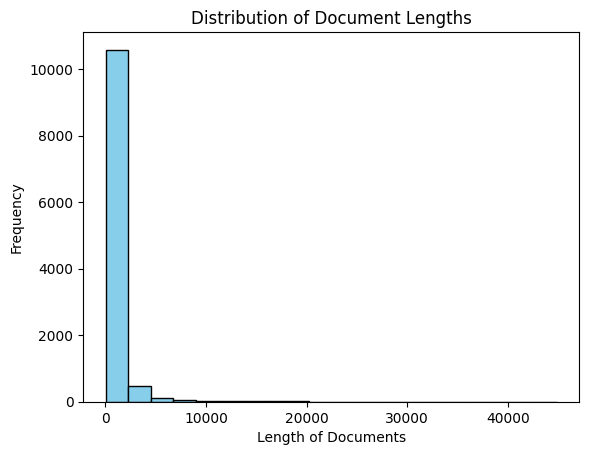

In [10]:
# Calculate the lengths of the documents
document_lengths = X_train['text'].apply(len)
Experiment.plot_distr(None, document_lengths)

To automatically pick those indices that have similar length, we will cluster documents based on their length with Bayesian Gaussian Mixture.
Bayesian Gaussian Mixture models return the weights of clusters with erroneous clusters being weighted at or near zero and basically removing those clusters automatically. With this method we do not have to priorly specify the number of clusters with great confidence.

In [11]:
X_train_filtered = filter_dataset_by_document_length(X_train)
X_test_filtered = filter_dataset_by_document_length(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Majority Cluster: 2
Number of indices belonging to the majority cluster: 5857
Number of indices of original dataset: 11314

Majority Cluster: 0
Number of indices belonging to the majority cluster: 3647
Number of indices of original dataset: 7532



/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Let's plot again the distribution of document lengths of the filtered now data.

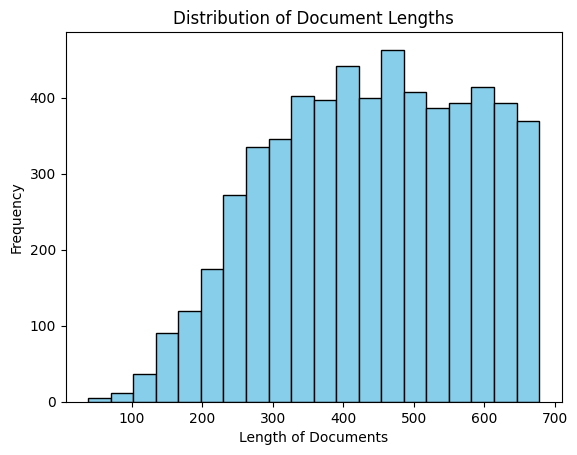

In [12]:
document_lengths = X_train_filtered['text'].apply(len)
Experiment.plot_distr(None, document_lengths)

Now our dataset is ready for the experiments.

In [13]:
data = {'train': X_train_filtered, 'test': X_test_filtered}

Now to the experiments. First we'll use a brute-force kNN model as our baseline model in order to get some ground truth neighbors and to later evaluate the results of MinHash LSH and also compare the execution times. In this baseline model we'll use BERT to create embeddings from our dataset.

In [34]:
# necessary instances
lsh = LSH()
knn = KNN(n_neighbors=32)
exp = Experiment(data, knn, lsh)

In [14]:
# Model 1: k-NearestNeighbors (brute force)
embeddings_train, embeddings_test = exp.prepare_data_knn()

knn_metrics = exp.knn_experiment(embeddings_train, embeddings_test)

neighbors_knn = knn_metrics['neighbors_knn']
time_knn_fit = knn_metrics['time_knn_fit']
time_knn_query = knn_metrics['time_knn_query']

Extracting BERT embeddings from the training dataset...
Extracting BERT embeddings from the test dataset....
Training NearestNeighbors...
Querying NearestNeighbors...


Next we'll use various parameters for MinHash LSH and conduct
several experiments to find insights about the parameters and
the accuracy of the model.

In [17]:
# Model 2: MinHash LSH
# We'll run several experiments for various parameters
X_train_shingles, X_test_shingles = exp.prepare_data_lsh(shingles_len=2)

experiments_data = {'train': X_train_shingles, 'test': X_test_shingles}
experiments_permutations = [128, 64, 32]
experiments_thresholds = list(float_range(0.1, 0.9, 0.1))

experiments_params = {'experiments_data': experiments_data,
                    'experiments_permutations': experiments_permutations,
                    'experiments_thresholds':experiments_thresholds}

experiments_metrics = exp.multiple_lsh_experiments(experiments_params)

experiments_neighbors = experiments_metrics['experiments_neighbors']
experiments_time_fit = experiments_metrics['experiments_time_fit']
experiments_time_query = experiments_metrics['experiments_time_query']
experiments_permutations = experiments_metrics['experiments_permutations']
experiments_thresholds = experiments_metrics['experiments_thresholds']

Commencing MinHash LSH experiments (27)...
LSH Experiment 0 - threshold: 0.1, n_perm: 128
LSH Experiment 1 - threshold: 0.1, n_perm: 64
LSH Experiment 2 - threshold: 0.1, n_perm: 32
LSH Experiment 3 - threshold: 0.2, n_perm: 128
LSH Experiment 4 - threshold: 0.2, n_perm: 64
LSH Experiment 5 - threshold: 0.2, n_perm: 32
LSH Experiment 6 - threshold: 0.3, n_perm: 128
LSH Experiment 7 - threshold: 0.3, n_perm: 64
LSH Experiment 8 - threshold: 0.3, n_perm: 32
LSH Experiment 9 - threshold: 0.4, n_perm: 128
LSH Experiment 10 - threshold: 0.4, n_perm: 64
LSH Experiment 11 - threshold: 0.4, n_perm: 32
LSH Experiment 12 - threshold: 0.5, n_perm: 128
LSH Experiment 13 - threshold: 0.5, n_perm: 64
LSH Experiment 14 - threshold: 0.5, n_perm: 32
LSH Experiment 15 - threshold: 0.6, n_perm: 128
LSH Experiment 16 - threshold: 0.6, n_perm: 64
LSH Experiment 17 - threshold: 0.6, n_perm: 32
LSH Experiment 18 - threshold: 0.7, n_perm: 128
LSH Experiment 19 - threshold: 0.7, n_perm: 64
LSH Experiment 20 - 

Now that we've gathered performance statistics for several
experiments, let's plot them to get some insights.

In [ ]:
# Evaluation: MinHash LSH
experiments_accuracy = exp.evaluate_experiments(
    neighbors_knn=neighbors_knn, experiments_neighbors_lsh=experiments_neighbors,
    experiments_thresholds=experiments_thresholds)

experiments_statistics = pd.DataFrame(columns=["n_perm",
                                            "threshold",
                                            "mean_accuracy",
                                            'time_fit',
                                            'time_query'])

pairs = list(zip(experiments_permutations, experiments_thresholds,
                experiments_accuracy, experiments_time_fit,
                experiments_time_query))

stats_df = pd.DataFrame(pairs, columns=experiments_statistics.columns)
experiments_statistics = pd.concat([experiments_statistics, stats_df], ignore_index=True)

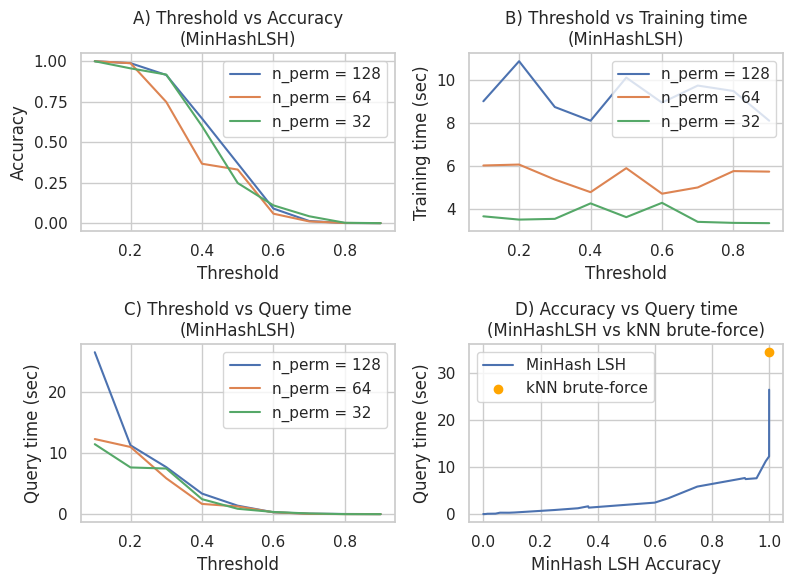

In [35]:
exp.plot_experiments(experiments_statistics, time_knn_fit, time_knn_query)

**By 'accuracy' we define the portion of the true neighbors that the MinHashLSH model managed to identify. Of course, with lower thresholds we have more chances to get the true neighbors in the predicted neighbors set, but also the true positives/negatives get higher, which means that in a classification task the majority vote (majority class) might be false. This requires a more precise calcuation of the 'accuracy', but for the purposes of this implementation we'll keep it simple.**

**plot A**: We can clearly see that threshold plays an important role to the accuracy of the MinHash LSH model, as expected. This is also true about the number of permutations (the more permutations the better accuracy under most threshold values.

**plot B**: An expected result, threshold plays no significant role in the training time of the MinHashLSH but number of permutations does. The more permutations the higher the training time.

**plot C**: There seems to be a relationship between threshold and query time. The smaller the threshold the larger the query time, which is obvious because the predicted neighbors set gets bigger. Also this is true for number of permutations, as the more permutations the more query time we seems to get.

**plot D**: Here we can see a clear demonstration of the MinHash LSH benefit, which is the fact that it can identify the true neighbors of a query with much less execution time than knn brute-force. Of course, remember the false positives/negatives trade-off.